In [23]:
import os,sys
import json
sys.path.append(os.path.abspath('..'))
import numpy as np
import random
import glob
import rate_methods as RM
from scipy import interpolate, optimize
from scipy.stats import ks_1samp, ks_2samp
from scipy.stats import gamma as gamma_func
import multiprocessing as mp
from functools import partial
import matplotlib.pyplot as plt


# EATR γ fitting

In [28]:
settings = {
    "FKBP_DMSO/SPIB0": 4,
    "FKBP_DMSO/SPIB1": 8,
    "FKBP_DMSO/SPIB2": 8,
    "FKBP_DMSO/SPIB3": 8,
    "FKBP_DMSO/SPIB4": 8,
}

# gammas     = np.arange(0.0, 1.01, 0.05)
# log_rates  = np.arange(-3.5, 8.1, 0.1)
gammas     = np.arange(0.0, 1.01, 0.5)
log_rates  = np.arange(-3.5, 8.1, 3)
colvar_name = "COLVAR_modified"
log_name    = colvar_name
plog_len    = 1
beta        = 0.3967641346
cores       = 4
random.seed(12345)


EATR_gamma_results = []

for directory, runs_count in settings.items():
    runs   = [f"run{i+1}" for i in range(runs_count)]
    colvars = [os.path.join(directory, r, colvar_name) for r in runs]
    plogs   = [os.path.join(directory, r, log_name)    for r in runs]

    # initialize
    colvars_count         = len(colvars)
    colvars_maxrow_count  = None
    data                  = []
    final_times           = np.zeros((colvars_count, 2))

    # load COLVARs
    for i, cv in enumerate(colvars):
        arr = np.loadtxt(cv)
        data.append(arr)
        # track max rows
        rows = arr.shape[0]
        if colvars_maxrow_count is None or rows > colvars_maxrow_count:
            colvars_maxrow_count = rows
        # record transition time
        final_times[i, 0] = arr[-1, 0]

    # compute acc and scaled times
    acc = RM.calc_acc(data, 0, 1, beta)
    final_times[:, 1] = final_times[:, 0] * acc

    # count events in plog files
    event = []
    for pl in plogs:
        with open(pl) as f:
            event.append(len(f.readlines()) > plog_len)
    event = np.array(event)
    M, N = event.sum(), len(event)
    t     = final_times[:, 0]

    # bootstrap opt gamma
    opt_gammas = []
    for _ in range(2):
        resample = random.choices(data, k=len(data))
        rows_list = [r.shape[0] for r in resample]
        max_rows  = max(rows_list)

        SSEs = []
        for gamma in gammas:
            v_data, ix_col = RM.inst_bias(resample,
                                          colvars_count,
                                          max_rows,
                                          beta, 1)
            spline = RM.EATR_calculate_avg_acc(gamma, v_data, beta, ix_col)
            ecdfx  = np.sort(t[event])
            ecdfy  = np.arange(1, M+1) / len(event)
            SSEs.append(
                RM.EATR_leastsq_cost(
                    10 ** (np.log10(1/13e-9) - 12),
                    gamma, ecdfx, ecdfy, spline
                )
            )
        opt_gammas.append(gammas[np.argmin(SSEs)])

    mean_gamma = np.mean(opt_gammas)
    std_gamma  = np.std(opt_gammas)
    print(f"{directory}: mean γ = {mean_gamma:.3f}, std = {std_gamma:.3f}")

    EATR_gamma_results.append( [mean_gamma, std_gamma])

# # ─── SAVE TO FILE ────────────────────────────────────────────────────────────
np.save('EATR_gamma_results.npy',EATR_gamma_results)

FKBP_DMSO/SPIB0: mean γ = 0.500, std = 0.000
FKBP_DMSO/SPIB1: mean γ = 0.500, std = 0.000
FKBP_DMSO/SPIB2: mean γ = 0.500, std = 0.000
FKBP_DMSO/SPIB3: mean γ = 0.500, std = 0.000
FKBP_DMSO/SPIB4: mean γ = 1.000, std = 0.000


# Average accelerated time

In [13]:
avg_accelerated_T= []
acc_factors= []
for directory, runs_count in settings.items():
    runs   = [f"run{i+1}" for i in range(runs_count)]
    colvars = [os.path.join(directory, r, colvar_name) for r in runs]
    
    data_list=[]
    # load COLVARs
    for i, cv in enumerate(colvars):
        locals()['metaD{0}'.format(i)] = np.loadtxt(cv)
        data_list.append(locals()['metaD{0}'.format(i)])
    residence_t_data=[]
    accelerated_factor=[]
    # Loop over the data points in 'data_list'
    for i in range(len(data_list)):
        simulation_data = data_list[i]
        # Extract the time and bias columns from the simulation data
        time = simulation_data[:,0]
        bias = simulation_data[:,-1]
        # Calculate the time step (dt)
        dt = (time[-1]-time[-2])*1e-12
        k_B = 8.314462
        T = 300
        kbT = k_B*T/1000

        # Calculate the acceleration factor
        acceleration = np.exp(bias/kbT)
        residence_t = acceleration*dt
        residence_t = np.sum(residence_t)
        # Add the calculated residence time to the list of residence time data
        residence_t_data.append(residence_t)
        accelerated_factor.append(residence_t/time[-1])
#     np.save('accelerated_data_iter_%i.npy'%i,accelerated_factor)
    acc_factors.append([accelerated_factor])
   
    avg_accelerated_T.append(np.mean(residence_t_data))

np.save('avg_accelerated_T.npy',avg_accelerated_T)    

# gamma fittings on predicted equations

In [80]:
!python gamma_predictions.py pred_params.json

γ prediction 1:  [-0.11813461 -0.13402314 -0.14218625 -0.13433946 -0.12988218]
γ prediction 2:  [-0.15253448 -0.15185679 -0.14712683 -0.13707525 -0.12209184]


In [81]:
gamma_predict = np.loadtxt('gamma_prediction.txt')

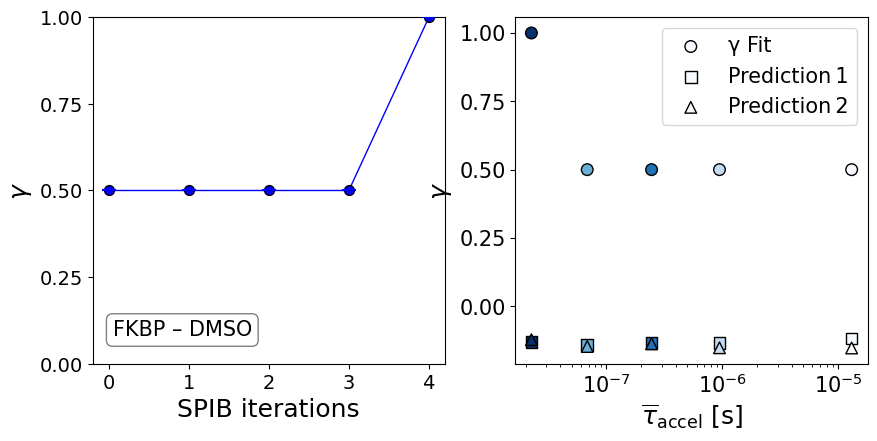

In [82]:
plt.figure(figsize = (10,4.5))
plt.subplot(1,2,1)
iters = np.arange(len(EATR_gamma_results))
gamma_vals = [row[0] for row in EATR_gamma_results]
gamma_vals_sig = [row[1] for row in EATR_gamma_results]

plt.plot(iters, gamma_vals, color='blue', linewidth=1, zorder=1)
plt.scatter(iters, gamma_vals, color='blue', s=50,
           edgecolor='black', linewidth=1, zorder=2)
plt.errorbar(iters, gamma_vals, yerr=gamma_vals_sig,
            fmt='none', ecolor='blue', elinewidth=1.5,
            capsize=5, capthick=1.5, zorder=3)


plt.ylabel(r'$\gamma$', fontsize=18)
plt.xlabel('SPIB iterations', fontsize=18)

plt.ylim(0, 1)
plt.yticks([0, 0.25, 0.5, 0.75, 1])
if i in [1, 2, 4, 5]:
    ax.set_yticklabels([])
    ax.set_ylabel('')

plt.tick_params(axis='y', labelsize=14)
plt.tick_params(axis='x', labelsize=14)
plt.text(0.05, 0.08, 'FKBP – DMSO', fontsize=15,
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))


plt.subplot(1,2,2)
τ    = avg_accelerated_T
sys  = gamma_vals
pred = gamma_predict

n_iter = len(τ)
cmap   = plt.cm.get_cmap('Blues', n_iter)
norm   = plt.Normalize(0, n_iter - 1)

series_info = [
    ('γ Fit',       'o', lambda s, p: s[:]),
    ('Prediction 1','s', lambda s, p: p[:, 1]),
    ('Prediction 2','^', lambda s, p: p[:, 2]),
]


iters = np.arange(n_iter)
for label, marker, getter in series_info:
    data = getter(sys, pred)
    plt.scatter(τ, data,
               c=iters, cmap=cmap, norm=norm,
               s=70, marker=marker, edgecolors='black', linewidths=1,
               label=label)

plt.xscale('log')
# plt.ylim(0, 1)
plt.xlabel(r'$\overline{\tau}_{\mathrm{accel}}$ [s]', fontsize=18)
plt.ylabel(r'$\gamma$', fontsize=18)
plt.yticks([0, 0.25, 0.5, 0.75, 1])
plt.tick_params(labelsize=15)
plt.legend(frameon=True, fontsize=15)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, pad=0.02, label='SPIB iteration')
cbar.ax.tick_params(labelsize=9)
